<h3 style="text-align: center;">HW3&4 - Wenjie Hu - 31/01/2024</h3>


In [3]:
import pandas as pd
import numpy as np
import gurobipy as gp
import random
import networkx as nx
import networkx.algorithms.approximation as nx_app
import time
from collections import namedtuple
from itertools import combinations
from itertools import permutations
from sklearn.metrics.pairwise import haversine_distances
from matplotlib import pyplot as plt
from matplotlib.patches import Circle
from gurobipy import GRB
from math import radians

In [ ]:
# ! export GRB_LICENSE_FILE=/Library/gurobi1001/macos_universal2/gurobi.lic
# ! grbprobe
# ! grbgetkey

# Ex1

In [47]:
def distance(row1, row2):
    pos1 = (row1['coordinates']['lat'], row1['coordinates']['lon'])
    pos2 = (row2['coordinates']['lat'], row2['coordinates']['lon'])
    radians1 = [radians(pos1[0]), radians(pos1[1])]
    radians2 = [radians(pos2[0]), radians(pos2[1])]
    res = haversine_distances([radians1, radians2])
    res *= 6371000 / 1000
    return res[0][1]

df = pd.read_json("dataset.json")
print(f"There are {len(df.index)} entries in the file overall.")
europe = df[df['timezone'].str.contains("Europe")]
print(f"There are {len(europe.index)} entries for towns in Europe.")
first_in_europe = europe.iloc[0]
second_in_europe = europe.iloc[-1]
print(f"The distance between {first_in_europe['name']} and {second_in_europe['name']} is "
      f"{distance(first_in_europe, second_in_europe)} km.")

poland = europe[europe['country_code'].str.contains('PL')]
print(f"There are {len(poland.index)} entries for towns in Poland.")
first_in_poland = poland.iloc[0]
second_in_poland = poland.iloc[1]

print(f"The distance between {first_in_poland['name']} and {second_in_poland['name']} is "
      f"{distance(first_in_poland, second_in_poland)} km.")

# The actual distance between Żurowa and Wyśmierzyce seems to be 219 kms, and the function claims 201 km.


There are 140807 entries in the file overall.
There are 69390 entries for towns in Europe.
The distance between Cerreto Castello and Saint-Melaine-sur-Aubance is 692.2505607394098 km.
There are 2872 entries for towns in Poland.
The distance between Żurowa and Wyśmierzyce is 201.5473452215105 km.


In order to better observe the results and visualise the data, we first use 100 cities as a subset of the data，and larger dataset tests followed.

In [54]:
poland_100 = poland[:100]
df = poland_100[['ascii_name','coordinates']]
# df = df.drop_duplicates()
df = df.set_index("ascii_name")
# df.reset_index(drop=True, inplace=True)

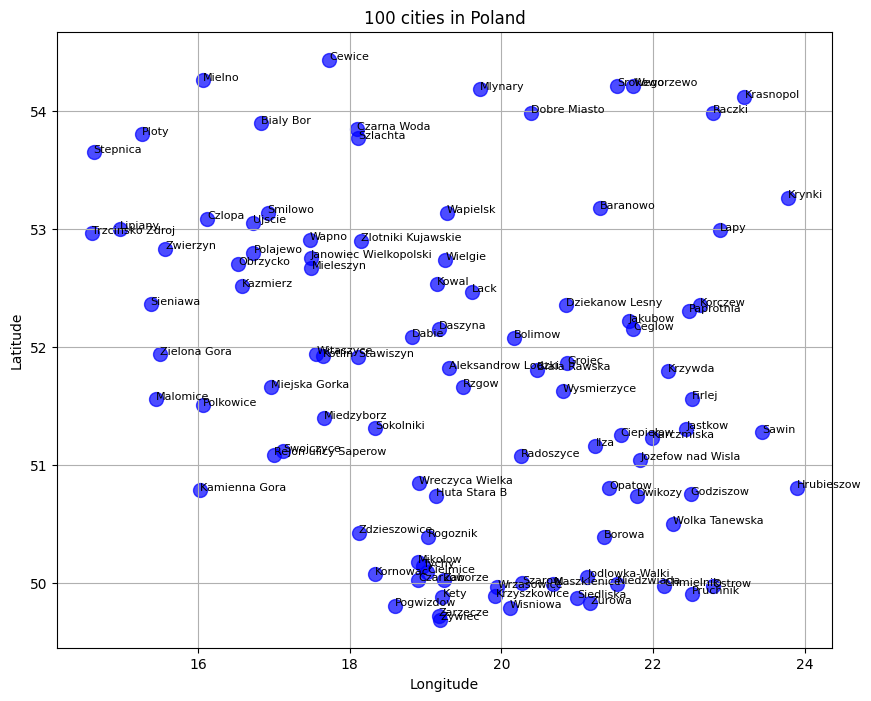

In [55]:
lats = [coord['lat'] for coord in df['coordinates']]
lons = [coord['lon'] for coord in df['coordinates']]

plt.figure(figsize=(10, 8))
plt.scatter(lons, lats, color='blue', s=100, alpha=0.7)

for i, txt in enumerate(df.index):
    plt.annotate(txt, (lons[i], lats[i]), fontsize=8)

plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('100 cities in Poland')
plt.grid(True)
plt.show()

In [56]:
def Steamboat_Willie(df, km_limit=50):
    s_time = time.time()
    m = gp.Model("steamboat_willies")
    stores = {}
    stores = m.addVars(df.index, vtype=GRB.BINARY, name="stores")
    m.setObjective(gp.quicksum(stores[i] for i in df.index), GRB.MINIMIZE)
    for i in df.index:
        m.addConstr(gp.quicksum(stores[j] for j in df.index if distance(df.loc[i], df.loc[j]) <= km_limit) >= 1)
    m.setParam(GRB.Param.OutputFlag, 0)
    m.optimize()

    stores_open = []
    for i, row in df.iterrows():
        if stores[i].x > 0.5:
            stores_open.append(i) 
    running_time  = time.time()-s_time
    return stores_open, running_time

In [58]:
stores_open, t = Steamboat_Willie(df)
print(f'Steamboat Willie needs to open {len(stores_open)} shops within the 50km limit')
df_open = (df[df.index.isin(stores_open)]).reset_index(drop=False)
df_open = pd.DataFrame(df_open)

Steamboat Willie needs to open 40 shops within the 50km limit


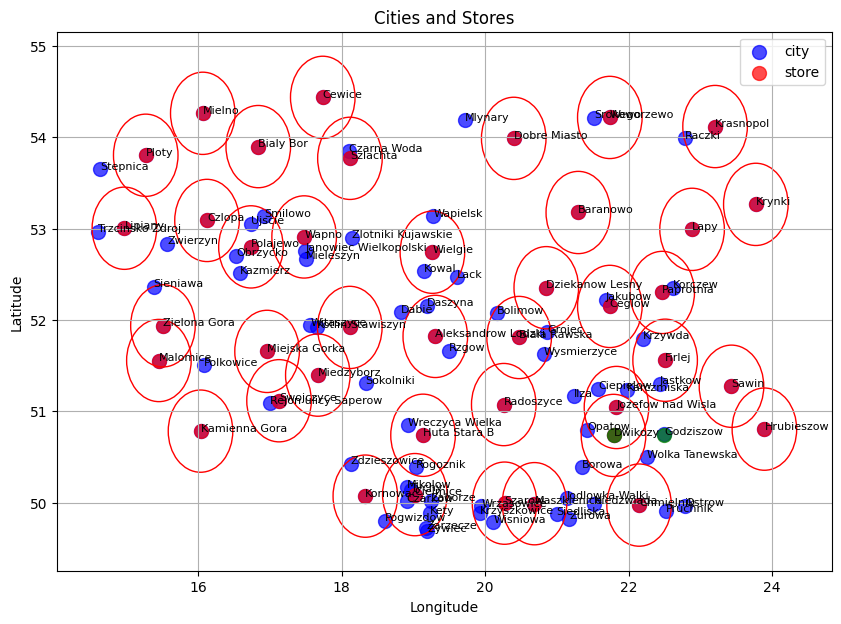

In [67]:
km_to_deg = 1 / 40000  * 360 
radius_km = 50
radius_deg = radius_km * km_to_deg

lats_o = [coord['lat'] for coord in df_open['coordinates']]
lons_o = [coord['lon'] for coord in df_open['coordinates']]
df.loc['Dwikozy']['coordinates']['lat']

plt.figure(figsize=(10, 7))
plt.scatter(lons, lats, color='blue', s=100, alpha=0.7, label = 'city')
plt.scatter(lons_o, lats_o, color='red', s=100, alpha=0.7, label = 'store')
plt.scatter(df.loc['Dwikozy']['coordinates']['lon'], df.loc['Dwikozy']['coordinates']['lat'], color='green', s=100, alpha=0.7)
plt.scatter(df.loc['Godziszow']['coordinates']['lon'], df.loc['Dwikozy']['coordinates']['lat'], color='green', s=100, alpha=0.7)
for i, txt in enumerate(df.index):
    plt.annotate(txt, (lons[i], lats[i]), fontsize=8)
for i, (lat, lon) in enumerate(zip(lats_o, lons_o)):
    circle = Circle((lon, lat), radius=radius_deg, color='red', fill=False)
    plt.gca().add_patch(circle)

plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Cities and Stores')
plt.grid(True)
plt.legend()
plt.show()

The chart above shows the number of shops Steamboat Willie's would need to open in the 100 selected Polish cities if he wanted to have a shop within 50km of each city. The blue points represent cities, the red points represent the city that owns a Steamboat Willie's, and the red circle represents a 50km radius. Unfortunately, due to projection, that red circle is much smaller than it actually is, as can be proved below.   
Look at the two green points on the map above, where Dwikozy owns a shop and Godziszow doesn't, Godziszow doesn't look like it's within Dwikozy's range, but in fact they are 49.9 kilometres apart, and the proof of the distance is given below

In [60]:
Dwikozy = df.loc['Dwikozy']
Godziszow = df.loc['Godziszow']
print(f'distance between Dwikozy and Godziszow is {distance(Dwikozy, Godziszow)} km')

distance between Dwikozy and Godziszow is 49.92978036397397 km


In [69]:
distances = pd.DataFrame(index=poland_100['ascii_name'], columns=df_open['ascii_name'])

for index1, row1 in poland_100.iterrows():
    for index2, row2 in df_open.iterrows():
        distances.at[row1['ascii_name'], row2['ascii_name']] = distance(row1, row2)

distance_matrix = distances.apply(pd.to_numeric)

In [70]:
distance_matrix

ascii_name,Wegorzewo,Szarow,Sawin,Radoszyce,Paprotnia,Czlopa,Cewice,Bialy Bor,Aleksandrow Lodzki,Swojczyce,...,Ploty,Mielno,Miejska Gorka,Miedzyborz,Malomice,Lipiany,Kornowac,Kamienna Gora,Huta Stara B,Cielmice
ascii_name,,,,,,,,,,,,,,,,,,,,,
Zurowa,489.610991,67.075020,226.985783,152.969273,289.702307,503.653170,563.408426,541.440932,257.448197,320.015088,...,599.627286,603.917727,359.309602,302.542850,446.238816,556.124084,205.048682,380.044399,176.631330,156.532478
Wysmierzyce,294.643777,185.225816,185.670114,72.407015,135.946333,357.758598,374.173958,367.971361,106.246422,262.208004,...,445.030016,432.599875,266.060503,219.305816,370.550425,425.693630,245.481959,346.089558,153.150483,212.286939
Wolka Tanewska,414.684047,152.330741,119.078837,154.569780,200.735473,510.762429,534.090717,528.288354,253.070539,367.228330,...,601.639619,592.809214,392.003403,336.911829,490.389601,573.586251,283.404851,440.365445,222.256383,234.799461
Wisniowa,504.687862,25.567565,286.923946,143.369897,324.191363,459.577882,541.676430,509.287827,233.007599,258.048716,...,556.853215,569.241206,304.126400,248.715256,382.945331,505.034029,131.717851,310.547831,126.626193,85.258963
Wegorzewo,0.000000,479.867237,346.389555,363.293731,218.402403,390.644858,260.651237,321.834546,312.169743,464.075603,...,425.159349,368.726039,428.321818,416.002991,514.880560,466.180538,516.015586,542.736751,424.959772,494.906844
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Kazmierz,390.703416,379.618541,489.579386,299.051874,399.692698,71.159174,226.918270,154.758538,200.872161,159.778262,...,168.069001,197.399911,98.703507,144.635684,131.692956,121.571304,297.305989,196.116279,264.393859,318.323049
Kamienna Gora,542.736751,313.002601,520.395204,298.035346,475.879984,256.426200,422.084535,350.499249,255.065518,85.152764,...,339.650736,386.710768,116.576375,133.033988,94.982917,257.385093,180.978794,0.000000,218.270538,225.308621
Janowiec Wielkopolski,324.457172,362.520929,438.695117,266.487072,340.443342,98.941054,187.470287,134.094889,161.424042,184.080410,...,188.065158,192.136909,127.574653,151.656475,192.765159,171.362230,304.060127,241.235889,251.267341,314.982219


To prove that the data is correct, here the distance matrix is calculated for all 100 cities and shops, where the rows represent the 100 cities and the columns represent the cities where the shops are located. The printed message below illustrates the nearest shops to the city and distance information，unprinted cities indicate that the city owns a shop.

In [71]:
print(f'City ---- Store ------ Distance')
for column in distances.columns:
    for index, value in distances[column].items():
        if value <= 50 and value !=0:
            print(f"[{index}, {column}], : {value:.2f} km")

City ---- Store ------ Distance
[Srokowo, Wegorzewo], : 13.94 km
[Wisniowa, Szarow], : 25.57 km
[Maszkienice, Szarow], : 29.81 km
[Wrzasowice, Szarow], : 23.45 km
[Krzyszkowice, Szarow], : 27.74 km
[Korczew, Paprotnia], : 11.50 km
[Zwierzyn, Czlopa], : 46.76 km
[Ujscie, Czlopa], : 41.01 km
[Daszyna, Aleksandrow Lodzki], : 38.22 km
[Dabie, Aleksandrow Lodzki], : 44.38 km
[Rzgow, Aleksandrow Lodzki], : 21.66 km
[Rejon ulicy Saperow, Swojczyce], : 9.32 km
[Miedzyborz, Swojczyce], : 48.88 km
[Zurowa, Maszkienice], : 39.00 km
[Wisniowa, Maszkienice], : 46.67 km
[Jodlowka-Walki, Maszkienice], : 32.62 km
[Szarow, Maszkienice], : 29.81 km
[Siedliska, Maszkienice], : 25.73 km
[Raczki, Krasnopol], : 30.92 km
[Opatow, Jozefow nad Wisla], : 39.05 km
[Karczmiska, Jozefow nad Wisla], : 23.39 km
[Ilza, Jozefow nad Wisla], : 43.37 km
[Dwikozy, Jozefow nad Wisla], : 34.12 km
[Ciepielow, Jozefow nad Wisla], : 29.07 km
[Krzywda, Firlej], : 33.81 km
[Jastkow, Firlej], : 28.77 km
[Wolka Tanewska, Dwikozy],

In [17]:
# linear programming relaxation of the integer programming problem
m = gp.Model()
x = m.addVars(df.index, lb=0, ub=1, name='x')
m.setObjective(gp.quicksum(x), GRB.MINIMIZE)

for i in df.index:
    for j in df.index:
        dist = distance(df.loc[i], df.loc[j])
        if dist <=50:
            m.addConstr(x[i] + x[j] >=1)
m.optimize()
print()
print(f"Steamboat Willie needs to open {m.objVal:.2f} stores for the restriction of 50km.")

Gurobi Optimizer version 10.0.0 build v10.0.0rc2 (mac64[x86])

CPU model: Intel(R) Core(TM) i5-1038NG7 CPU @ 2.00GHz
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 364 rows, 100 columns and 628 nonzeros
Model fingerprint: 0x614aaf4f
Coefficient statistics:
  Matrix range     [1e+00, 2e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Presolve removed 364 rows and 100 columns
Presolve time: 0.01s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    5.0000000e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds (0.00 work units)
Optimal objective  5.000000000e+01

Steamboat Willie needs to open 50.00 stores for the restriction of 50km.


In 10 cities, Steamboat Willie needs to open 6 shops within the 50km limit -- 0.11881184577941895 s-- 
In 110 cities, Steamboat Willie needs to open 41 shops within the 50km limit -- 6.1731860637664795 s-- 
In 210 cities, Steamboat Willie needs to open 43 shops within the 50km limit -- 21.85179305076599 s-- 
In 310 cities, Steamboat Willie needs to open 44 shops within the 50km limit -- 46.73558688163757 s-- 
In 410 cities, Steamboat Willie needs to open 44 shops within the 50km limit -- 88.94486713409424 s-- 
In 510 cities, Steamboat Willie needs to open 43 shops within the 50km limit -- 138.2593970298767 s-- 
In 610 cities, Steamboat Willie needs to open 45 shops within the 50km limit -- 199.48779487609863 s-- 
In 710 cities, Steamboat Willie needs to open 46 shops within the 50km limit -- 272.04315090179443 s-- 
In 810 cities, Steamboat Willie needs to open 48 shops within the 50km limit -- 336.0994188785553 s-- 
In 910 cities, Steamboat Willie needs to open 48 shops within the 50km

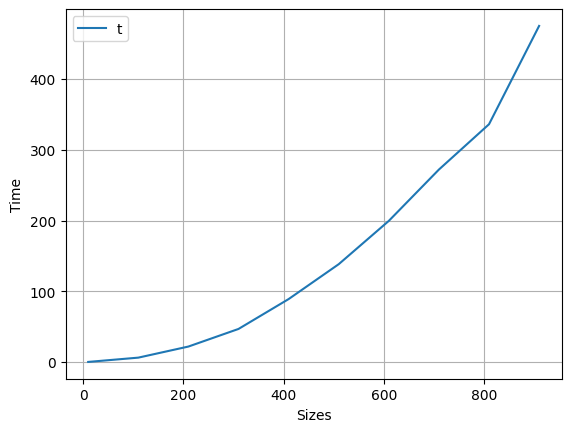

In [73]:
sizes = [i for i in range(10, 1001, 100)]
t_s = []
for s in sizes:
    df = poland[:s]
    stores_open, t = Steamboat_Willie(df)
    t_s.append(t)
    print(f'In {s} cities, Steamboat Willie needs to open {len(stores_open)} shops within the 50km limit -- {t} s-- ')
plt.clf() 
plt.plot(sizes, t_s, label='t')
plt.xlabel('Sizes')
plt.ylabel('Time')
# plt.title('D')
plt.legend()
plt.grid(True)
plt.show()


As can be seen from the graph above, the algorithm grows exponentially in time, processing a subset of 910 cities with a runtime of 475 seconds on an Intel(R) Core(TM) i5-1038NG7 CPU @ 2.00GHz, and for larger datasets will require longer runtimes。

# Ex2

ref:  
https://how-to.aimms.com/Articles/332/332-Explicit-Dantzig-Fulkerson-Johnson-formulation.html  
https://dm872.github.io/assets/dm872-TSP_Formulations.pdf  
https://github.com/Arthod/LP-tsp-gurobi/tree/main   
https://blog.csdn.net/weixin_53463894/article/details/128230017

ILP method

In [74]:
df = df[:50]
lon_lat_list = [(row['coordinates']['lon'], row['coordinates']['lat']) for index, row in df.iterrows()]
lon_lat_index = [(index, row['coordinates']['lon'], row['coordinates']['lat']) for index, row in df.iterrows()]

In [75]:
dists_matrix = pd.DataFrame(index=df.index, columns=df.index)
for index1, row1 in df.iterrows():
    for index2, row2 in df.iterrows():
        dists_matrix.at[index1, index2] = distance(df.loc[index1], df.loc[index2])
dist_list = {(i, j): dists_matrix.iloc[i, j] for i, row1 in enumerate(dists_matrix) for j, row2 in enumerate(dists_matrix) if i != j}

In [76]:
def get_route(lon_lat, dist_list):
    N = len(lon_lat)
    u_stations = list(range(N))
    m = gp.Model()
    x = m.addVars(dist_list.keys(), vtype=GRB.BINARY, name='x')
    u = m.addVars(u_stations, vtype=GRB.CONTINUOUS, name='u')

    m.addConstrs(gp.quicksum(x[i,j] for j in u_stations if j!=i)==1 for i in u_stations) 
    m.addConstrs(gp.quicksum(x[i,j] for i in u_stations if j!=i)==1 for j in u_stations) 
    m.addConstrs((x[i,j]==1) >> (u[i]+1==u[j]) for i,j in dist_list.keys() if j!=0) 
    m.setObjective(gp.quicksum(dist_list[arc]*x[arc] for arc in dist_list.keys()), GRB.MINIMIZE)
    m.setParam(GRB.Param.OutputFlag, 0)
    m.optimize()

    connection = {k[0]: k[1] for k, v in zip(dist_list.keys(), m.getVars()) if v.X > 0.5}
    head = 0
    res = [head]
    [res.append(connection[head]) or (head := connection[head]) for _ in range(N-1)]
    return res


Interrupt request received


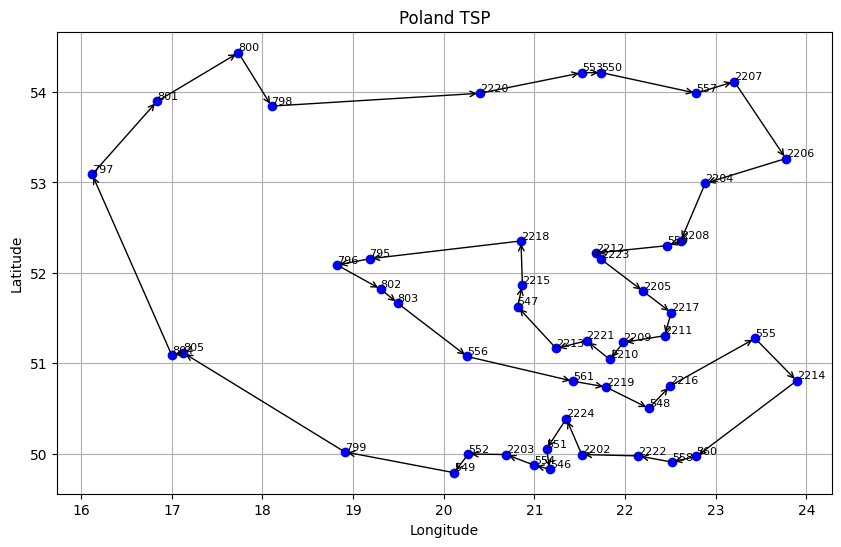

In [77]:
route = get_route(lon_lat_list, dist_list)

x_coords = [point[1] for point in lon_lat_index]
y_coords = [point[2] for point in lon_lat_index]

plt.figure(figsize=(10, 6))
plt.plot(x_coords, y_coords, 'bo')
plt.title('Poland TSP')

for i in range(len(route) - 1):
    plt.annotate('', xy=(x_coords[route[i + 1]], y_coords[route[i + 1]]), 
                 xytext=(x_coords[route[i]], y_coords[route[i]]),
                 arrowprops=dict(arrowstyle="->", color='black'))

plt.annotate('', xy=(x_coords[route[0]], y_coords[route[0]]),
             xytext=(x_coords[route[-1]], y_coords[route[-1]]),
             arrowprops=dict(arrowstyle="->", color='black'))

for i, point in enumerate(lon_lat_index):
    plt.text(point[1], point[2], point[0], fontsize=8, ha='left', va='bottom')

plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.grid(True)
plt.show()

This algorithm is very bad and takes $O(N^2 + M)$

In [78]:
##########

Dantzig-Fulkerson-Johnson algorithm

In [5]:
def get_dist(x1,y1,x2,y2):
    radians1 = [radians(x1), radians(y1)]
    radians2 = [radians(x2), radians(y2)]
    res = haversine_distances([radians1, radians2])
    res *= 6371000 / 1000
    return res[0][1]

def get_G(size):
    df = poland[:size]
    df = df[['ascii_name','coordinates']].set_index("ascii_name")
    global lon_lat_index
    lon_lat_index = [(index, row['coordinates']['lon'], row['coordinates']['lat']) for index, row in df.iterrows()]
    n = len(lon_lat_index)
    G = nx.complete_graph(n) 
    pos = {}
    for i in G.nodes:
        random_x = lon_lat_index[i][1]
        random_y = lon_lat_index[i][2]
        pos[i] = (random_x, random_y)
    for i,j in G.edges:
        (x1,y1) = pos[i]
        (x2,y2) = pos[j]
        dist = get_dist(x1,y1,x2,y2)
        G.add_edge(i, j, weight=dist)    
        G.edges[i,j]['distance'] = dist
    return G, pos, df


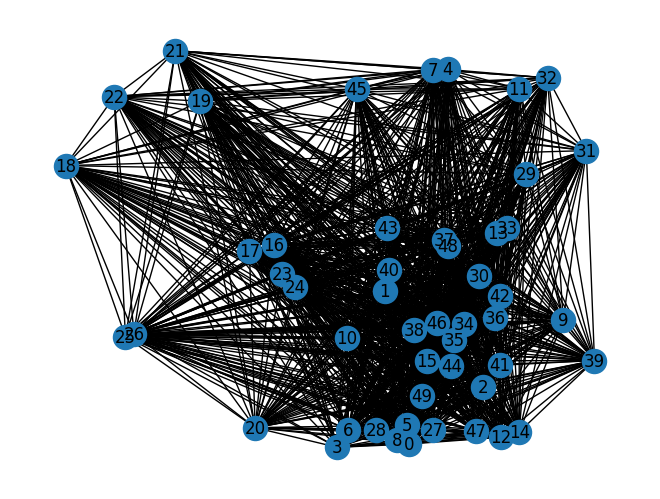

In [9]:
G, pos, df_50 = get_G(50)
nx.draw(G, pos=pos, with_labels=True)

In [10]:
lon_lat_index = [(index, row['coordinates']['lon'], row['coordinates']['lat']) for index, row in df.iterrows()]

Determine whether a subtour has been generated, and if so, add the corresponding constraints and re-opt the whole model until the resulting solution excludes the subtour

In [11]:
def DFJ(G, pos, draw=False):
    start_time = time.time()
    m = gp.Model()
    m.setParam(GRB.Param.OutputFlag, 0)
    x = m.addVars(G.edges, vtype=GRB.BINARY)
    m.setObjective(gp.quicksum(G.edges[e]['distance'] * x[e] for e in G.edges), GRB.MINIMIZE)
    m.addConstrs(gp.quicksum(x[e] for e in G.edges if e in G.edges(i)) == 2 for i in G.nodes) # enter n leave
    m.optimize()
    tour = [e for e in G.edges if x[e].x > 0.5]
    while not nx.is_connected(G.edge_subgraph(tour)):
        for subtour in nx.connected_components(G.edge_subgraph(tour)): # elimination inequality 
            inner_edges = [(i, j) for (i, j) in G.edges if i in subtour and j in subtour]
            m.addConstr(gp.quicksum(x[e] for e in inner_edges) <= len(subtour) - 1)
        m.optimize()
        tour = [e for e in G.edges if x[e].x > 0.5]
        
        if draw:
            plt.figure()
            nx.draw(G.edge_subgraph(tour), pos=pos, with_labels = True)
            plt.title(f"DFJ - {len(pos)} cities")

    end_time = time.time() 
    running_time = end_time - start_time
    return running_time

Set parameter Username


Academic license - for non-commercial use only - expires 2024-05-30


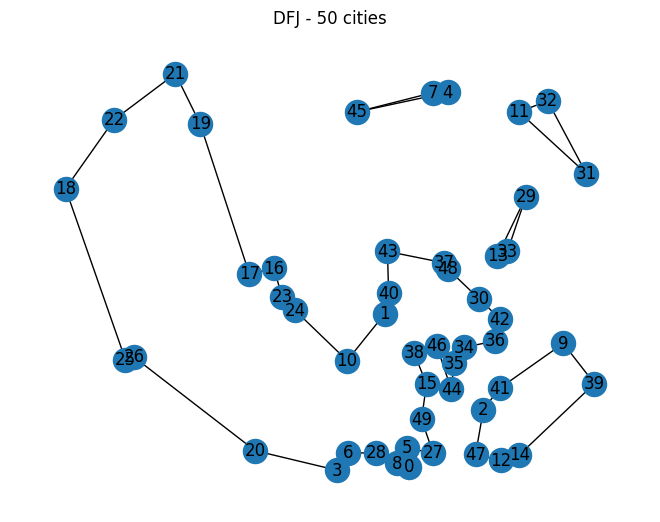

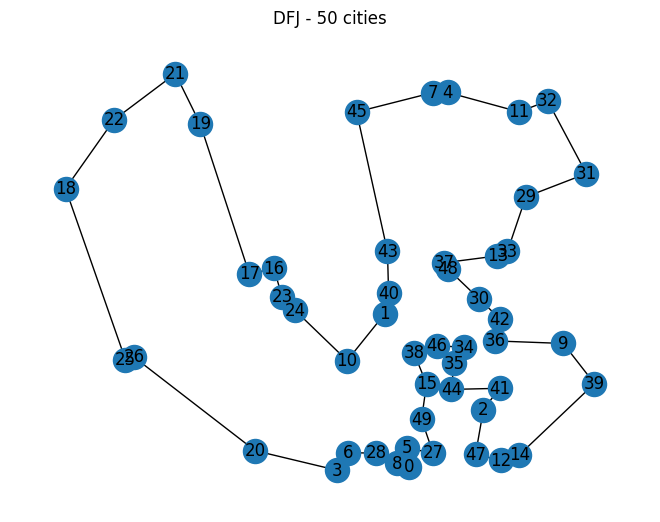

In [12]:
_= DFJ(G, pos, draw=True)

The number of constraints is $O(2^n)$, the number of decision variables is $O(2^n)$ as well.

In [13]:
def subtourelim(m, where):
    if where == GRB.Callback.MIPSOL: 
        vals = m.cbGetSolution(m._x)
        selected_edges = [ e for e in m._G.edges if vals[e] > 0.5 ]       
        for subtour in nx.connected_components( m._G.edge_subgraph( selected_edges ) ):
            if len(subtour) <= m._G.number_of_nodes() / 2:                
                inner_edges = [ (i,j) for (i,j) in m._G.edges if i in subtour and j in subtour ]
                m.cbLazy( gp.quicksum( m._x[e] for e in inner_edges ) <= len(subtour) - 1 )

Dantzig-Fulkerson-Johnson lazy

During the solution process, once an integer solution is searched, the callback function is called to add constraints. Since the solution is based on the cut-plane method, the process does not need to stop.

In [14]:
# lazy row generation version

def DFJ_lazy(G, pos, draw=False):
    start_time = time.time()
    m = gp.Model()
    x = m.addVars(G.edges, vtype=GRB.BINARY)
    m.setParam(GRB.Param.OutputFlag, 0)
    m.setObjective(gp.quicksum(G.edges[e]['distance'] * x[e] for e in G.edges), GRB.MINIMIZE)
    m.addConstrs(gp.quicksum(x[e] for e in G.edges if e in G.edges(i)) == 2 for i in G.nodes)
    m.update()
    m.Params.lazyConstraints = 1
    m._x = x
    m._G = G
    m.optimize(subtourelim)
    
    tour_edges = [ e for e in G.edges if x[e].x > 0.5 ]
    
    nx.draw(G.edge_subgraph(tour_edges), pos=pos, with_labels = True)
    plt.title(f"DFJ lazy - {len(pos)} cities")
    
    end_time = time.time() 
    running_time = end_time - start_time
    return running_time


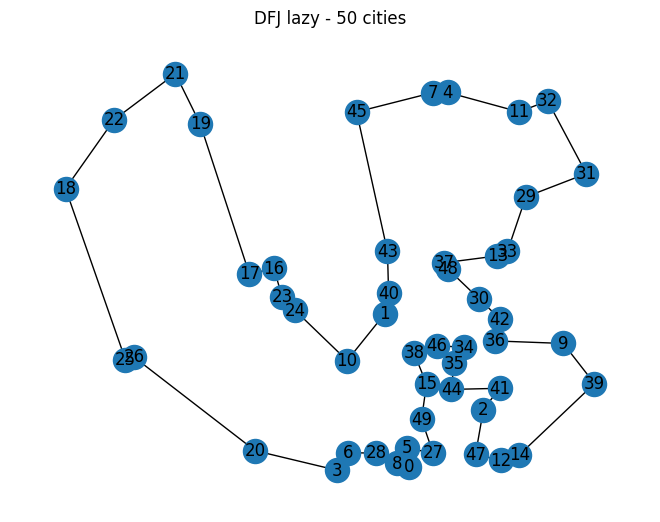

In [15]:
_ = DFJ_lazy(G, pos, draw=True)

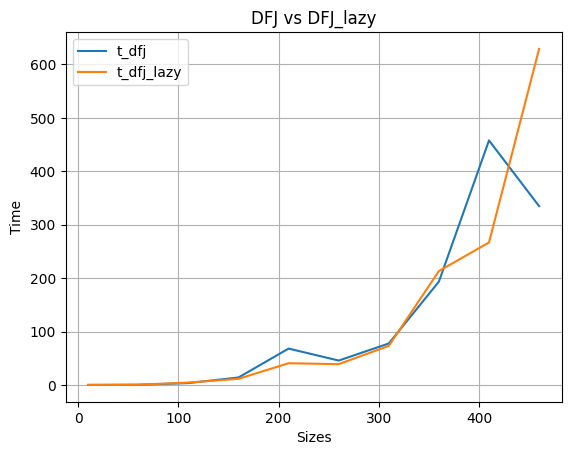

In [77]:
sizes = [i for i in range(10, 501, 50)]
t_dfj = []
t_dfj_lazy = []
for s in sizes:
    G, pos= get_G(s)
    t_dfj.append(DFJ(G, pos, draw=False))
    t_dfj_lazy.append(DFJ_lazy(G, pos, draw=False))
    plt.clf() 

plt.plot(sizes, t_dfj, label='t_dfj')
plt.plot(sizes, t_dfj_lazy, label='t_dfj_lazy')
plt.xlabel('Sizes')
plt.ylabel('Time')
plt.title('DFJ vs DFJ_lazy')
plt.legend()
plt.grid(True)
plt.show()

The graph compares the two algorithms at 10, 60, 110,... 460 cities in terms of running efficiency. Interestingly, the model with uses subsets to eliminate subtours may seem to be slower than the callback method, but in reality it is not necessarily the case; in the experiment above, DFJ's model found the opt solution faster at 460 cities, and we can say that it is possible to be faster with the eliminate subtours method in some few cases as well. In short, the algorithm takes exponential time. I can process 460 city-sized TSPs in 10 minutes on my computer, and with more time should be able to process more than 1000 TSP.

# Ex3

ref:  
https://blog.csdn.net/meiyoushui_/article/details/114949295  
https://networkx.org/documentation/stable/auto_examples/drawing/plot_tsp.html  

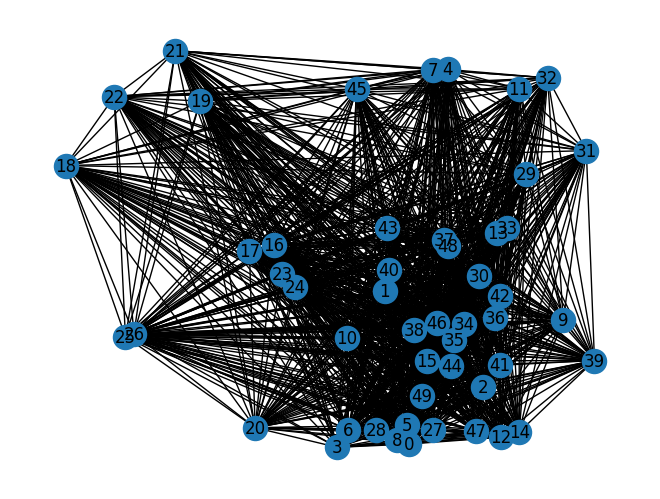

In [29]:
H, pos, df_ = get_G(50)
nx.draw(H, pos=pos, with_labels=True)

The route of the traveller is: [0, 27, 5, 49, 15, 44, 35, 46, 38, 1, 34, 36, 42, 41, 2, 47, 12, 14, 39, 9, 30, 37, 48, 13, 33, 29, 31, 11, 32, 4, 7, 45, 43, 40, 10, 24, 23, 16, 17, 26, 25, 18, 22, 21, 19, 20, 3, 6, 28, 8, 0]


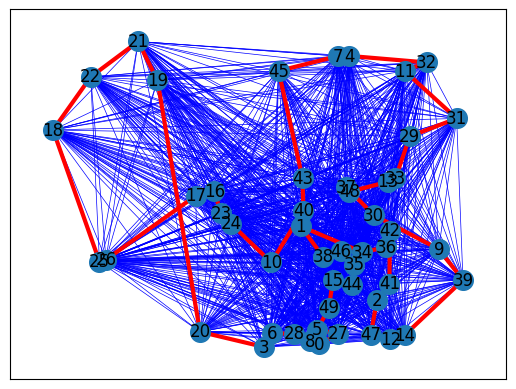

In [33]:
cycle = nx_app.christofides(H, weight="distance")
edge_list = list(nx.utils.pairwise(cycle))
nx.draw_networkx_edges(H, pos, edge_color="blue", width=0.5)
nx.draw_networkx(
    H,
    pos,
    with_labels=True,
    edgelist=edge_list,
    edge_color="red",
    node_size=200,
    width=3,
)

print("The route of the traveller is:", cycle)
plt.show()

In [19]:
#####
def get_H(size):
    df = poland[:size]
    df = df[['ascii_name','coordinates']].set_index("ascii_name")
    lon_lat_index = [(index, row['coordinates']['lon'], row['coordinates']['lat']) for index, row in df.iterrows()]
    # start, *rest, end = [lon_lat_index[i][0] for i in range(len(lon_lat_index))]
    # paths = [(start, *path, end) for path in permutations(rest)]
    # G = nx.prefix_tree(paths)
    # G.remove_nodes_from([0, -1])
    G = nx.Graph()
    for i in range(len(lon_lat_index)-1):
        G.add_node(i)
        dist = get_dist(lon_lat_index[i][1],lon_lat_index[i][2],lon_lat_index[i+1][1],lon_lat_index[i+1][2])
        # print(dist)
        G.add_edge(i, i+1, weight = dist)
    return G

$G = (V,E)$, $V_1$ deg is  even, $V_2$ deg is odd  
$2m = \sum_{v\in V}deg(v)=\sum_{v\in V_1}deg(v)+\sum_{v\in V_2}deg(v)$

<img src="https://img-blog.csdnimg.cn/20210318092316659.png" alt="g">


In [84]:
def Christofides(H, pos=None, draw=False):
    start_time = time.time()

    min_tree = nx.minimum_spanning_tree(H)

    Odd_min = [node * -1  for node  in min_tree.nodes if min_tree.degree(node) % 2 != 0 ] 

    Odd = nx.complete_graph(Odd_min)   
    min_matching = nx.min_weight_matching(Odd, maxcardinality=True) 

    edges_to_add = [(i[0] * -1, i[1] * -1) for i in min_matching]
    min_tree.add_edges_from(edges_to_add)
    # eulerian_circuit = [u for u, v in nx.eulerian_circuit(min_tree)]
    # nodes = eulerian_circuit
    nodes = []
    for u, v in nx.eulerian_circuit(min_tree): # short cutting
        if v in nodes:
            continue
        if not nodes:
            nodes.append(u)
        nodes.append(v)
    nodes.append(nodes[0])
    
    end_time = time.time() 
    running_time = end_time - start_time
    if draw:
        nx.draw_networkx(H, pos, with_labels=True, edgelist= list(nx.utils.pairwise(nodes)),
            edge_color="red", node_size=len(nodes),width=3,)
    return nodes, running_time

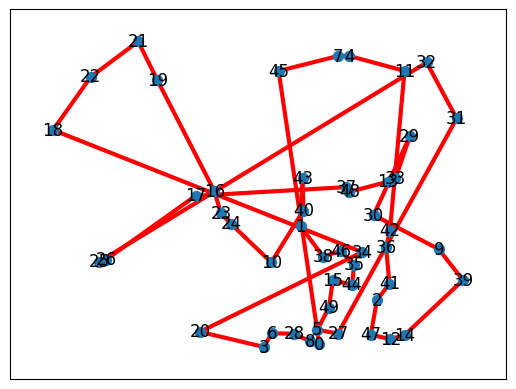

In [85]:
H,pos,_ = get_G(50)
n, t = Christofides(H,pos ,draw=True)


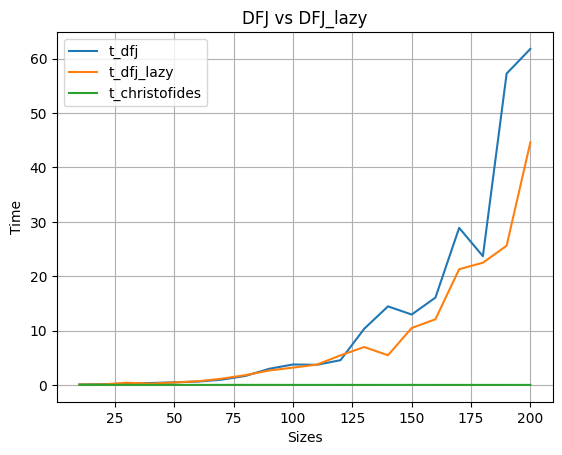

In [97]:
sizes = [i for i in range(10, 201, 10)]
t_dfj = []
t_dfj_lazy = []
t_christofides = []

for s in sizes:
    G, pos, _= get_G(s)
    H  = get_H(s)
    t_dfj.append(DFJ(G, pos, draw=False))
    t_dfj_lazy.append(DFJ_lazy(G, pos, draw=False))
    _, t = Christofides(H,draw=False)
    t_christofides.append(t)
    plt.clf() 

plt.plot(sizes, t_dfj, label='t_dfj')
plt.plot(sizes, t_dfj_lazy, label='t_dfj_lazy')
plt.plot(sizes, t_christofides, label='t_christofides')
plt.xlabel('Sizes')
plt.ylabel('Time')
plt.title('DFJ vs DFJ_lazy')
plt.legend()
plt.grid(True)
plt.show()

It looks fast, but my mothod can't find the optimal solution :(